<a href="https://colab.research.google.com/github/NielsRogge/Transformers-Tutorials/blob/master/AST/Inference_with_the_Audio_Spectogram_Transformer_to_classify_audio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Set-up environment

First we install 🤗 Transformers.

In [ ]:
!pip install -q git+https://github.com/huggingface/transformers.git

rm: cannot remove 'transformers': No such file or directory
Cloning into 'transformers'...
remote: Enumerating objects: 151566, done.
remote: Counting objects: 100% (441/441), done.
remote: Compressing objects: 100% (156/156), done.
remote: Total 151566 (delta 299), reused 347 (delta 244), pack-reused 151125
Receiving objects: 100% (151566/151566), 125.62 MiB | 17.78 MiB/s, done.
Resolving deltas: 100% (112322/112322), done.
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 182 kB 10

## Load audio

Let's load some audio on which we'd like to test the model.

In [1]:
from huggingface_hub import hf_hub_download
import IPython

filepath = hf_hub_download(repo_id="nielsr/audio-spectogram-transformer-checkpoint",
                           filename="sample_audio.flac",
                           repo_type="dataset")

IPython.display.Audio(filepath)

/remote-home/pjli/anaconda3/envs/audio/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Prepare audio for the model (using feature extractor)

We can prepare the audio using ASTFeatureExtractor, which turns it into a tensor of shape (batch_size, time_dimension, frequency_dimension). This is also known as a spectrogram.

In [2]:
from transformers import ASTFeatureExtractor

feature_extractor = ASTFeatureExtractor()

In [3]:
import torchaudio

waveform, sampling_rate = torchaudio.load(filepath)
waveform = waveform.squeeze().numpy()

print(waveform.shape)
print(sampling_rate)

(160125,)
16000


In [5]:
inputs = feature_extractor(waveform, sampling_rate=sampling_rate, padding="max_length" ,return_tensors="pt")
input_values = inputs.input_values
print(input_values.shape)

torch.Size([1, 1024, 128])


In [6]:
import torch
spectrogram = input_values.squeeze(0)
print(spectrogram.shape)
print(torch.max(spectrogram),torch.min(spectrogram),torch.mean(spectrogram))

torch.Size([1024, 128])
tensor(0.8129) tensor(-1.2776) tensor(-0.1971)


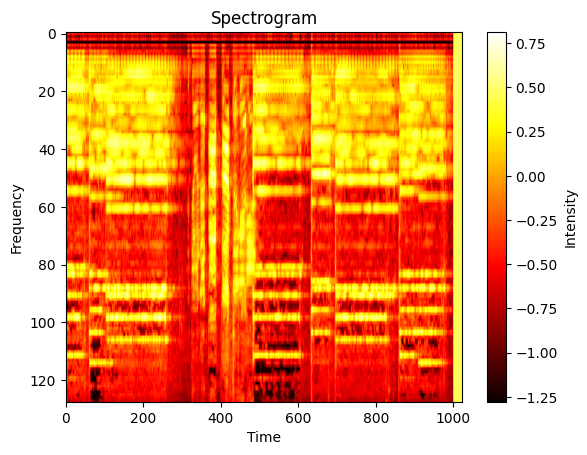

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# 假设你的频谱图存储在变量spectrogram中
spectrogram = input_values.squeeze(0)
spectrogram = spectrogram.permute(1,0)

# 可视化频谱图
plt.imshow(spectrogram, cmap='hot', aspect='auto')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.colorbar(label='Intensity')
plt.title('Spectrogram')
plt.show()


## Load model

Next we load one of the models that the AST authors released from the [hub](https://huggingface.co/models?other=audio-spectrogram-transformer).

This one was fine-tuned on AudioSet, an important benchmark for audio classification.

In [ ]:
from transformers import AutoModelForAudioClassification

model = AutoModelForAudioClassification.from_pretrained("MIT/ast-finetuned-audioset-10-10-0.4593")

Downloading:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/346M [00:00<?, ?B/s]

## Forward pass

Next let's forward the audio through the model! We perform an argmax on the model's logits to get the predicted class index. We use model.config.id2label to turn that back into text.

In [ ]:
import torch

with torch.no_grad():
  outputs = model(input_values)

In [ ]:
predicted_class_idx = outputs.logits.argmax(-1).item()
print("Predicted class:", model.config.id2label[predicted_class_idx])

Predicted class: Organ
